# Compute $\boldsymbol{J}$ in Kinetic Energy

We can define the rotational kinetic energy of a single body as

$$
\frac{1}{2} \boldsymbol{\omega}^{T} \boldsymbol{I} \boldsymbol{\omega}=\frac{1}{2} \operatorname{tr}\left([\boldsymbol{\omega}] \boldsymbol{J}[\boldsymbol{\omega}]^{T}\right),
$$

where $\boldsymbol{J}$ is a diagonal PD matrix that ensures the equality above holds. The following notebook derives the definition of $\boldsymbol{J}$.

In [1]:
import numpy
import sympy.vector
from IPython.display import Latex, Math, display
from sympy import *

init_printing()

In [2]:
def hat(x):
    return numpy.array([[0, -x[2], x[1]], [x[2], 0, -x[0]], [-x[1], x[0], 0]],
                       dtype=x.dtype)

In [3]:
omega = numpy.array(symbols("omega_x omega_y omega_z"))
I = numpy.diag(symbols("I_x I_y I_z"))
J = numpy.diag(symbols("J_0 J_1 J_2"))

In [4]:
lhs = omega.T @ I @ omega
display(lhs.collect(omega))
lhs_coeffs = [lhs.coeff(omega[i], 2) for i in range(omega.size)]
display(lhs_coeffs)

In [5]:
rhs = numpy.trace(hat(omega) @ J @ hat(omega).T)
display(rhs.collect(omega))
rhs_coeffs = [rhs.coeff(omega[i], 2) for i in range(omega.size)]
display(rhs_coeffs)

<IPython.core.display.Latex object>

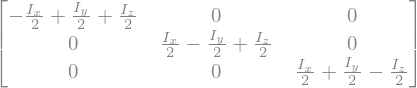

In [6]:
eqs = [
    Eq(lhs_coeff, rhs_coeff)
    for lhs_coeff, rhs_coeff in zip(lhs_coeffs, rhs_coeffs)
]
display(eqs)
J_of_I = solve(eqs, numpy.diag(J).tolist())
J_solved = numpy.diag([J_of_I[numpy.diag(J)[i]] for i in range(3)])
display(Latex("$\\boldsymbol{J}=$"), Matrix(J_solved))

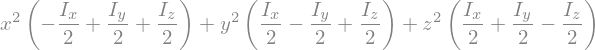

In [7]:
x = numpy.array(symbols("x y z"), dtype=Symbol)
(x.T @ J_solved @ x).collect(numpy.diag(I))

# Derivatives of $Q=exp(a)$
\begin{align*}
Q  &= I + \sin(\|a\|)\left[\frac{a}{\|a\|}\right] + (1 - \cos(\|a\|))\left[\frac{a}{\|a\|}\right]\left[\frac{a}{\|a\|}\right]\\
Q  &= I + \frac{\sin(\|a\|)}{\|a\|}[a] + \frac{(1 - \cos(\|a\|))}{\|a\|^2}[a]^2 \\
Q  &= I + \text{sinc}(\|a\|)[a] + \frac{2\sin^2\left(\frac{\|a\|}{2}\right)}{\|a\|^2}[a]^2 \\
Q  &= I + \text{sinc}(\|a\|)[a] + \frac{1}{2}\text{sinc}^2\left(\frac{\|a\|}{2}\right)[a]^2 \\
\end{align*}
where $a$ is an rotation vector.

In [9]:
def norm(x):
    return sqrt(sum(x**2))


def sinc(x):
    if x == 0:
        return 1
    return sin(x) / x

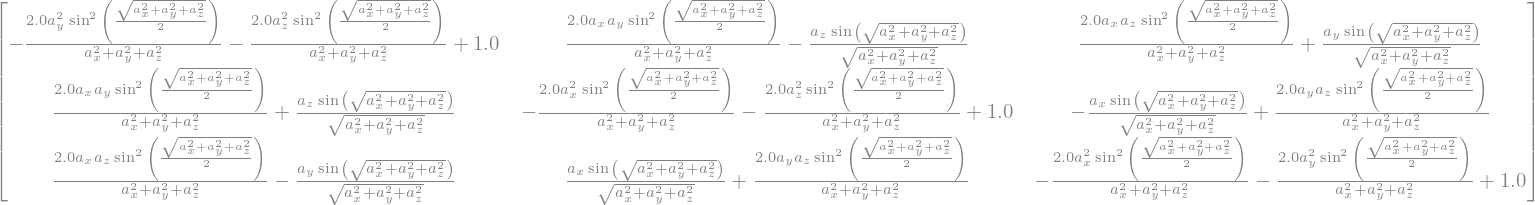

In [10]:
a = numpy.array(symbols("a_x a_y a_z"))
angle = norm(a)
K = hat(a)
Q = numpy.eye(3) + sinc(angle) * K + 0.5 * sinc(angle / 2)**2 * K @ K
display(Matrix(Q))

In [11]:
R = numpy.array(Matrix(Q).subs(dict(zip(
    a, 100 * numpy.random.random(3))))).astype(float)
assert (numpy.linalg.norm((R.T @ R) - numpy.eye(3)) < 1e-12)
assert (abs(numpy.linalg.det(R) - 1) < 1e-12)

In [12]:
Q_grad = Matrix(Q).diff(a)
Q_grad.shape

In [14]:
Q_hess = Q_grad.diff(a)
Q_grad.shape

In [15]:
Q_t = numpy.array([[0.999802263127325, 0, -0.0198855386016856], [0, 1, 0],
                   [0.0198855386016856, 0, 0.999802263127325]])
Qdot_t = numpy.array([[0.0474679356776831, 0, 2.38658607479242], [0, 0, 0],
                      [-2.38658607479242, 0, 0.0474679356776831]])
Q_t.T @ Qdot_t

array([[-1.26897989e-16,  0.00000000e+00,  2.38705808e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-2.38705808e+00,  0.00000000e+00, -1.23976861e-16]])

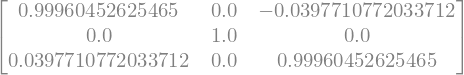

In [17]:
# A = numpy.array(symbols([f"A_{i}" for i in range(9)])).reshape(3, 3)
Q_t = numpy.array([[0.999802263127325, 0, -0.0198855386016856], [0, 1, 0],
                   [0.0198855386016856, 0, 0.999802263127325]])
Qdot_t = numpy.array([[0.0474679356776831, 0, 2.38658607479242], [0, 0, 0],
                      [-2.38658607479242, 0, 0.0474679356776831]])
Qdot_t = numpy.array([[-0.0197736872674992, 0, -1.98855386016856], [0, 0, 0],
                      [1.98855386016856, 0, -0.0197736872674992]])
# Qdot_t = numpy.zeros((3, 3))
h = 0.01
A = Q_t + h * Qdot_t
display(Matrix(A))

In [18]:
E = 0.5 * numpy.trace(Q @ J @ Q.T) - numpy.trace(Q @ J @ (A.T))

In [19]:
E_grad = E.diff(a)
E_grad.shape

In [20]:
E_hess = E_grad.diff(a)
E_hess.shape

In [21]:
E.subs(dict(zip(a, [0, 6.26329845777282, 0]))).subs(
    dict(zip(numpy.diag(J), [0.0833333333333333] * 3)))

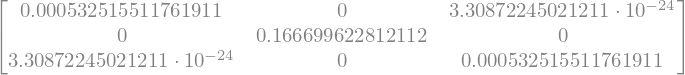

In [22]:
H = E_hess.subs(dict(zip(a, [0, 6.26329845777282, 0]))).subs(
    dict(zip(numpy.diag(J), [0.0833333333333333] * 3)))
display(H)
H = numpy.array(H.tolist()).astype(float)

In [23]:
evals, evectors = numpy.linalg.eig(H)
evals[evals < 0] = 0
evectors @ numpy.diag(evals) @ evectors.T

array([[0.00053252, 0.        , 0.        ],
       [0.        , 0.16669962, 0.        ],
       [0.        , 0.        , 0.00053252]])

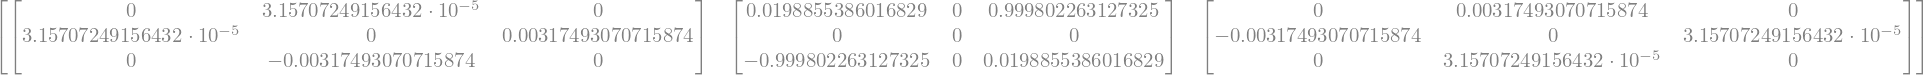

In [24]:
Q_grad = sympy.tensor.array.dense_ndim_array.ImmutableDenseNDimArray(Q_grad)
Q_grad.subs(dict(zip(a, [0, 6.26329845777282, 0])))

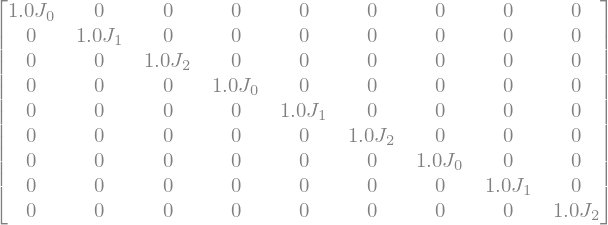

In [25]:
def foo():
    Q = numpy.array(symbols([f"Q_{i}" for i in range(9)])).reshape(3, 3)
    E = 0.5 * numpy.trace(Q @ J @ Q.T) - numpy.trace(Q @ J @ (A.T))
    E_grad = E.diff(Q.flatten())
    E_hess = E_grad.diff(Q.flatten())
    display(E_hess)


foo()

$$
\nabla_a f(Q=R(a)) = \nabla_Q f(R(a)) \nabla_a R(a)
$$

In [26]:
axis_angle = Symbol("a")
energy = Function("f")
rotation = Function("R")

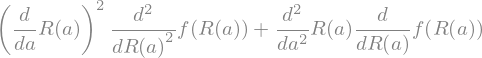

In [27]:
energy(rotation(axis_angle)).diff(axis_angle).diff(axis_angle)

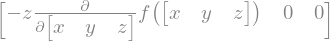

In [28]:
f = Function("f")
x = numpy.array(symbols("x y z"))
# Matrix(hat(x)@hat(x)).diff(x).diff(x)
R = I + f(x) * hat(x) + 1 / 2 * (f(x / 2))**2 * hat(x) @ hat(x)
R[0, 0].diff(x)
display(Matrix(f(x) * hat(x))[0, 1])
(f(x) * hat(x))[0, 1].diff(x)

# Solve Indefinite system with LDLT

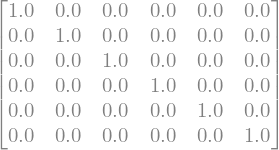

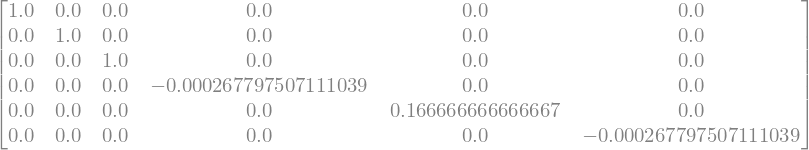

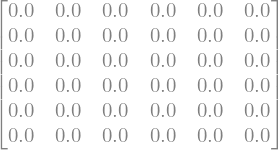

array([0., 0., 0., 0., 0., 0.])

In [32]:
A = [[1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0],
     [0, 0, 0, -0.000267797507111039, 0,
      0], [0, 0, 0, 0, 0.166666666666667, 0],
     [0, 0, 0, 0, 0, -0.000267797507111039]]
b = numpy.array([-0, -0, -0, -0, 0.00523526215594216, -0])

import scipy.linalg
L, D, P = scipy.linalg.ldl(numpy.array(A))
display(Matrix(L))
display(Matrix(D))
display(Matrix(L @ D @ L.T - A))
A @ (scipy.linalg.solve_triangular(
    L,
    scipy.linalg.solve_triangular(D, scipy.linalg.solve_triangular(L.T, b)),
    lower=True)) - b